# Summary

# Imports

In [1]:
import concurrent.futures
import itertools
import multiprocessing
import os
import os.path as op
import pickle
import subprocess
import tempfile
from functools import partial
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import sqlalchemy as sa
from scipy import stats

from kmtools import py_tools, sequence_tools

In [2]:
%matplotlib inline

In [3]:
pd.set_option("max_columns", 100)

# Parameters

In [4]:
NOTEBOOK_PATH = Path('validation_homology_models')
NOTEBOOK_PATH

PosixPath('validation_homology_models')

In [5]:
OUTPUT_PATH = Path(os.getenv('OUTPUT_DIR', NOTEBOOK_PATH.name)).resolve()
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH

PosixPath('/scratch/strokach/datapkg/adjacency-net-v2/notebooks/validation_homology_models')

In [ ]:
proc = subprocess.run(["git", "rev-parse", "--short", "HEAD"], stdout=subprocess.PIPE)
GIT_REV = proc.stdout.decode().strip()
GIT_REV

In [6]:
TASK_ID = os.getenv("SLURM_ARRAY_TASK_ID")
TASK_COUNT = os.getenv("ORIGINAL_ARRAY_TASK_COUNT") or os.getenv("SLURM_ARRAY_TASK_COUNT")
NETWORK_NAME = os.getenv("NETWORK_NAME", GIT_REV)

TASK_ID = int(TASK_ID) if TASK_ID is not None else None
TASK_COUNT = int(TASK_COUNT) if TASK_COUNT is not None else None

TASK_ID, TASK_COUNT

(None, None)

In [7]:
DEBUG = "CI" not in os.environ    
DEBUG

True

In [8]:
if DEBUG:
    NETWORK_NAME = "dcn_old_0,9c5a963"
else:
    assert NETWORK_NAME is not None
    
NETWORK_NAME

'dcn_old_0,9c5a963'

In [9]:
# if DEBUG:
#     %load_ext autoreload
#     %autoreload 2

# `DATAPKG`

In [10]:
DATAPKG = {}

In [11]:
DATAPKG['uniparc-domain-wstructure'] = (
    Path(os.environ['DATAPKG_OUTPUT_DIR'])
    .joinpath("uniparc-domain-wstructure", "master")
)

In [12]:
DATAPKG['adjacency_net_v2'] = (
    Path(os.environ['DATAPKG_OUTPUT_DIR'])
    .joinpath("adjacency_net_v2", "master")
)

In [13]:
DATAPKG['hhsuite-wstructure'] = {
    'pdb_homology_modeling': 
        Path(os.environ['DATAPKG_OUTPUT_DIR']).joinpath(
            "hhsuite-wstructure",
            "master",
            "pdb_homology_modeling",
        ),
    'pdb_homology_modeling_adjacency_matrix': 
        Path(os.environ['DATAPKG_OUTPUT_DIR']).joinpath(
            "hhsuite-wstructure",
#             "master",
#             "354abf6aa8a49dded9955be5580bde4d6ac10c60",
            "e062231f4490081db273d21ec832acb18f36bcbb",
            "pdb_homology_modeling_adjacency_matrix",
        ),
    'pdb_homology_modeling_rosetta_score':  
        Path(os.environ['DATAPKG_OUTPUT_DIR']).joinpath(
            "hhsuite-wstructure",
#             "master",
            "09ae1a7157c6c98e8b7bdd93b0e7e6d4cf7587fc",
            "pdb_homology_modeling_rosetta_score",
        ),
}

# Network evaluation

In [14]:
%run trained_networks.ipynb

In [15]:
def predict_with_dcn_old(input_, network_info, network_state):
    from pagnn.prediction.dcn_old import Args, main
    for adj_col in ['adjacency_idx_1', 'adjacency_idx_2']:
        input_[adj_col] = input_.apply(lambda row: np.r_[row[adj_col], 0:len(row['sequence'])], axis=1).values
    args = Args(network_info=network_info, network_state=network_state)
    output_df = main(args, input_)
    return output_df

In [16]:
def predict_with_dcn(input_, network_info, network_state):
    from pagnn.prediction.dcn import Args, main
    args = Args(network_info=network_info, network_state=network_state)
    output_df = main(args, input_)
    return output_df

# Load data

### `pdb_homology_modeling`

In [17]:
homology_model_files = (
    sorted(DATAPKG['hhsuite-wstructure']['pdb_homology_modeling'].glob('*-?.parquet')) +
    sorted(DATAPKG['hhsuite-wstructure']['pdb_homology_modeling'].glob('*-??.parquet'))    
)

assert len(homology_model_files) == 10
homology_model_files[:2]

[PosixPath('/scratch/strokach/datapkg_output_dir/hhsuite-wstructure/master/pdb_homology_modeling/uniprot20_2016_02-pdb70-1.parquet'),
 PosixPath('/scratch/strokach/datapkg_output_dir/hhsuite-wstructure/master/pdb_homology_modeling/uniprot20_2016_02-pdb70-2.parquet')]

In [18]:
columns = [
    "unique_id", "query_id",

    "dope_score", "ga341_score", "dope_score_norm", "molpdf",
    
    "identity_calc", "coverage_calc",

    "score", "similarity", "sum_probs",
    "evalue", "probability", "identity",

    "query_ali", "template_ali",
    "query_match_length", "template_match_length",
    
    "sequence",
    'hm_residue_idx_1', 'hm_residue_idx_2',
    "adjacency_idx_1_from_pdb", "adjacency_idx_2_from_pdb", 
    "adjacency_idx_1_from_hm", "adjacency_idx_2_from_hm",
]

pdb_homology_modeling = (
    pq.ParquetDataset(homology_model_files)
    .read_pandas(columns=columns)
    .to_pandas()
)

In [19]:
display(pdb_homology_modeling.head(1))
print(len(pdb_homology_modeling))

,unique_id,query_id,dope_score,ga341_score,dope_score_norm,molpdf,identity_calc,coverage_calc,score,similarity,sum_probs,evalue,probability,identity,query_ali,template_ali,query_match_length,template_match_length
0,33091-1:142-5IM6_P-1:143,33091,-15450.600586,1.0,-1.219322,631.898438,0.34507,1.0,271.19,0.528,131.8,7.100000e-45,100.0,0.35,WKDSPIIEANGTLDELTSFIGEAKHYVD-EEMKGILEEIQNDIYKI...,MGDDARIAAIGDVDELNSQIGVLLAEPLPDDVRAALSAIQHDLFDL...,142,143


126946


### `pdb_homology_modeling_adjacency_matrix`

In [20]:
pdb_homology_modeling_adjacency_matrix_files = sorted(
    DATAPKG
    ['hhsuite-wstructure']
    ['pdb_homology_modeling_adjacency_matrix']
    .glob('*-???.parquet')
)

assert len(pdb_homology_modeling_adjacency_matrix_files) == 10
pdb_homology_modeling_adjacency_matrix_files[:2]

[PosixPath('/scratch/strokach/datapkg_output_dir/hhsuite-wstructure/e062231f4490081db273d21ec832acb18f36bcbb/pdb_homology_modeling_adjacency_matrix/uniprot20_2016_02-pdb70-001.parquet'),
 PosixPath('/scratch/strokach/datapkg_output_dir/hhsuite-wstructure/e062231f4490081db273d21ec832acb18f36bcbb/pdb_homology_modeling_adjacency_matrix/uniprot20_2016_02-pdb70-002.parquet')]

In [21]:
dfs = []
for file in pdb_homology_modeling_adjacency_matrix_files:
    df = pq.read_table(file, columns=columns, use_pandas_metadata=True).to_pandas()
    dfs.append(df)
    

pdb_homology_modeling_adjacency_matrix = pd.concat(dfs)

In [22]:
# pdb_homology_modeling_adjacency_matrix = (
#     pq.ParquetDataset(pdb_homology_modeling_adjacency_matrix_files)
#     .read_pandas()
#     .to_pandas()
# )

In [23]:
display(pdb_homology_modeling_adjacency_matrix.head(1))
print(len(pdb_homology_modeling_adjacency_matrix))

,unique_id,sequence,hm_residue_idx_1,hm_residue_idx_2,adjacency_idx_1_from_pdb,adjacency_idx_2_from_pdb,adjacency_idx_1_from_hm,adjacency_idx_2_from_hm
0,33091-1:142-5IM6_P-1:143,WKDSPIIEANGTLDELTSFIGEAKHYVDEEMKGILEEIQNDIYKIM...,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, ...","[1, 2, 3, 4, 5, 113, 114, 0, 2, 3, 4, 5, 6, 11...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 2, 3, 4, 5, 114, 0, 2, 3, 4, 5, 6, 110, 11...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, ...","[1, 2, 3, 4, 5, 112, 113, 0, 2, 3, 4, 5, 6, 11..."


126935


### `pdb_homology_modeling_rosetta_score`

In [24]:
files = sorted(
    DATAPKG
    ['hhsuite-wstructure']
    ['pdb_homology_modeling_rosetta_score']
    .glob('*-???-?.parquet')
)

len(files)

100

In [25]:
pdb_homology_modeling_rosetta_score = (
    pq.ParquetDataset(files)
    .read_pandas()
    .to_pandas()
)

In [26]:
display(pdb_homology_modeling_rosetta_score.head(1))
print(len(pdb_homology_modeling_rosetta_score))

,error,rosetta_dslf_fa13,rosetta_fa_atr,rosetta_fa_dun,rosetta_fa_elec,rosetta_fa_intra_rep,rosetta_fa_intra_sol_xover4,rosetta_fa_rep,rosetta_fa_sol,rosetta_hbond_bb_sc,rosetta_hbond_lr_bb,rosetta_hbond_sc,rosetta_hbond_sr_bb,rosetta_linear_chainbreak,rosetta_lk_ball_wtd,rosetta_omega,rosetta_overlap_chainbreak,rosetta_p_aa_pp,rosetta_pro_close,rosetta_rama_prepro,rosetta_ref,rosetta_score,rosetta_time,rosetta_total_score,rosetta_yhh_planarity,unique_id
index,,,,,,,,,,,,,,,,,,,,,,,,,,
0,None,0.0,-860.044,183.683,-235.861,1.919,29.217,126.713,577.373,-7.876,0.0,-16.129,-101.769,0.0,-26.435,7.398,0.0,-15.139,0.105,18.31,43.337,-275.172,0.0,-275.172,0.026,33091-1:142-5IM6_P-1:143


126454


### `homology_models_dataset`

In [27]:
homology_models_dataset = (
    pdb_homology_modeling
    .merge(pdb_homology_modeling_adjacency_matrix, left_index=True, right_index=True, suffixes=("", "_2"))
    .merge(pdb_homology_modeling_rosetta_score, left_index=True, right_index=True, suffixes=("", "_3"))
)

assert (homology_models_dataset['unique_id'] == homology_models_dataset['unique_id_2']).all()
del homology_models_dataset['unique_id_2']

assert (homology_models_dataset['unique_id'] == homology_models_dataset['unique_id_3']).all()
del homology_models_dataset['unique_id_3']

# assert len(homology_models_dataset) == len(pdb_homology_modeling)

In [28]:
homology_models_dataset['sequence'] = homology_models_dataset['query_ali'].str.replace('-', '')

In [29]:
display(homology_models_dataset.head(1))
print(len(homology_models_dataset))

,unique_id,query_id,dope_score,ga341_score,dope_score_norm,molpdf,identity_calc,coverage_calc,score,similarity,sum_probs,evalue,probability,identity,query_ali,template_ali,query_match_length,template_match_length,sequence,hm_residue_idx_1,hm_residue_idx_2,adjacency_idx_1_from_pdb,adjacency_idx_2_from_pdb,adjacency_idx_1_from_hm,adjacency_idx_2_from_hm,error,rosetta_dslf_fa13,rosetta_fa_atr,rosetta_fa_dun,rosetta_fa_elec,rosetta_fa_intra_rep,rosetta_fa_intra_sol_xover4,rosetta_fa_rep,rosetta_fa_sol,rosetta_hbond_bb_sc,rosetta_hbond_lr_bb,rosetta_hbond_sc,rosetta_hbond_sr_bb,rosetta_linear_chainbreak,rosetta_lk_ball_wtd,rosetta_omega,rosetta_overlap_chainbreak,rosetta_p_aa_pp,rosetta_pro_close,rosetta_rama_prepro,rosetta_ref,rosetta_score,rosetta_time,rosetta_total_score,rosetta_yhh_planarity
0,33091-1:142-5IM6_P-1:143,33091,-15450.600586,1.0,-1.219322,631.898438,0.34507,1.0,271.19,0.528,131.8,7.100000e-45,100.0,0.35,WKDSPIIEANGTLDELTSFIGEAKHYVD-EEMKGILEEIQNDIYKI...,MGDDARIAAIGDVDELNSQIGVLLAEPLPDDVRAALSAIQHDLFDL...,142,143,WKDSPIIEANGTLDELTSFIGEAKHYVDEEMKGILEEIQNDIYKIM...,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, ...","[1, 2, 3, 4, 5, 113, 114, 0, 2, 3, 4, 5, 6, 11...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 2, 3, 4, 5, 114, 0, 2, 3, 4, 5, 6, 110, 11...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, ...","[1, 2, 3, 4, 5, 112, 113, 0, 2, 3, 4, 5, 6, 11...",None,0.0,-860.044,183.683,-235.861,1.919,29.217,126.713,577.373,-7.876,0.0,-16.129,-101.769,0.0,-26.435,7.398,0.0,-15.139,0.105,18.31,43.337,-275.172,0.0,-275.172,0.026


126443


In [30]:
for query_id, group in homology_models_dataset.groupby('query_id'):
    assert (group['sequence'].str.replace('-', '') == group['sequence'].iloc[0].replace('-', '')).all()
    assert (group['query_match_length'] == group['query_match_length'].iloc[0]).all()

## Statistics

In [31]:
display(homology_models_dataset.head(2))
print(len(homology_models_dataset))
print(len(set(homology_models_dataset['query_id'])))

,unique_id,query_id,dope_score,ga341_score,dope_score_norm,molpdf,identity_calc,coverage_calc,score,similarity,sum_probs,evalue,probability,identity,query_ali,template_ali,query_match_length,template_match_length,sequence,hm_residue_idx_1,hm_residue_idx_2,adjacency_idx_1_from_pdb,adjacency_idx_2_from_pdb,adjacency_idx_1_from_hm,adjacency_idx_2_from_hm,error,rosetta_dslf_fa13,rosetta_fa_atr,rosetta_fa_dun,rosetta_fa_elec,rosetta_fa_intra_rep,rosetta_fa_intra_sol_xover4,rosetta_fa_rep,rosetta_fa_sol,rosetta_hbond_bb_sc,rosetta_hbond_lr_bb,rosetta_hbond_sc,rosetta_hbond_sr_bb,rosetta_linear_chainbreak,rosetta_lk_ball_wtd,rosetta_omega,rosetta_overlap_chainbreak,rosetta_p_aa_pp,rosetta_pro_close,rosetta_rama_prepro,rosetta_ref,rosetta_score,rosetta_time,rosetta_total_score,rosetta_yhh_planarity
0,33091-1:142-5IM6_P-1:143,33091,-15450.600586,1.0,-1.219322,631.898438,0.345070,1.0,271.19,0.528,131.8,7.100000e-45,100.0,0.35,WKDSPIIEANGTLDELTSFIGEAKHYVD-EEMKGILEEIQNDIYKI...,MGDDARIAAIGDVDELNSQIGVLLAEPLPDDVRAALSAIQHDLFDL...,142,143,WKDSPIIEANGTLDELTSFIGEAKHYVDEEMKGILEEIQNDIYKIM...,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, ...","[1, 2, 3, 4, 5, 113, 114, 0, 2, 3, 4, 5, 6, 11...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 2, 3, 4, 5, 114, 0, 2, 3, 4, 5, 6, 110, 11...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, ...","[1, 2, 3, 4, 5, 112, 113, 0, 2, 3, 4, 5, 6, 11...",None,0.0,-860.044,183.683,-235.861,1.919,29.217,126.713,577.373,-7.876,0.0,-16.129,-101.769,0.0,-26.435,7.398,0.0,-15.139,0.105,18.310,43.337,-275.172,0.0,-275.172,0.026
1,33091-1:142-3KE4_C-41:189,33091,-15394.823242,1.0,-1.191503,1064.089966,0.359155,1.0,270.51,0.533,131.6,9.500000e-45,100.0,0.36,WKDSPIIEANGTLDELTSFIGEAKHYVDE----EMKGILEEIQNDI...,DKDDIRVEAYGTIDEANSHIGYAMTKLQGGAFIDIYNELENIQHEL...,142,149,WKDSPIIEANGTLDELTSFIGEAKHYVDEEMKGILEEIQNDIYKIM...,"[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, ...","[1, 2, 3, 6, 0, 2, 3, 6, 0, 1, 3, 4, 6, 0, 1, ...","[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, ...","[1, 2, 3, 6, 0, 2, 3, 6, 0, 1, 3, 4, 0, 1, 2, ...","[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, ...","[1, 2, 3, 6, 0, 2, 3, 6, 0, 1, 3, 4, 6, 0, 1, ...",None,0.0,-850.958,187.585,-233.608,1.953,27.797,122.979,564.869,-13.660,0.0,-18.957,-102.922,0.0,-21.572,6.870,0.0,-11.066,0.109,-3.246,43.337,-300.326,0.0,-300.326,0.162


126443
6713


In [32]:
def hist(col, range, *args, **kwargs):
    x = homology_models_dataset[col]
    x = np.clip(x, *range)
    with plt.rc_context(rc={"font.size": 12}):
        plt.hist(x, range=range, **kwargs)
        plt.title(col)

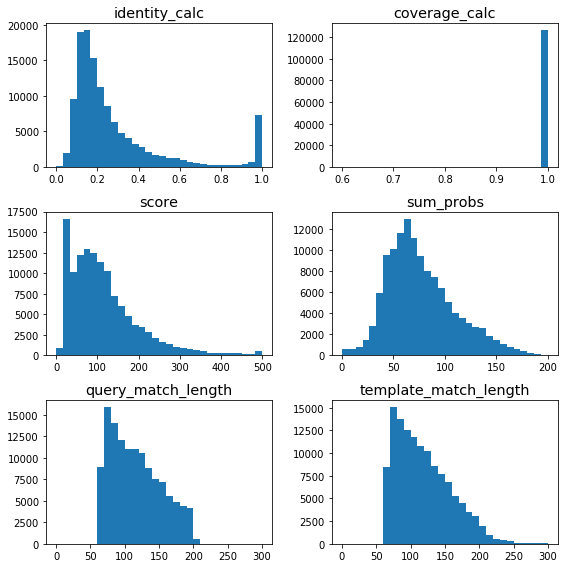

In [33]:
fg, axs = plt.subplots(3, 2, figsize=(8, 8))

plt.sca(axs[0, 0])
hist("identity_calc", range=(0, 1), bins=30)

plt.sca(axs[0, 1])
hist("coverage_calc", range=(0.6, 1), bins=30)

plt.sca(axs[1, 0])
hist("score", range=(0, 500), bins=30)

plt.sca(axs[1, 1])
hist("sum_probs", range=(0, 200), bins=30)

plt.sca(axs[2, 0])
hist("query_match_length", range=(0, 300), bins=30)

plt.sca(axs[2, 1])
hist("template_match_length", range=(0, 300), bins=30)

plt.tight_layout()

## Validation

### Fraction of sequence covered by adj

In [34]:
homology_models_dataset["frac_aa_wadj_pdb"] = (
    homology_models_dataset["adjacency_idx_1_from_pdb"].apply(lambda l: len(set(l))) /
    homology_models_dataset['sequence'].str.len()
)

homology_models_dataset["frac_aa_wadj_hm"] = (
    homology_models_dataset["adjacency_idx_1_from_hm"].apply(lambda l: len(set(l))) /
    homology_models_dataset['sequence'].str.len()
)

homology_models_dataset["frac_aa_wadj_hm2"] = (
    homology_models_dataset["hm_residue_idx_1"].apply(lambda l: len(set(l))) /
    homology_models_dataset['sequence'].str.len()
)

Text(0.5, 0, 'frac_aa_wadj_hm2')

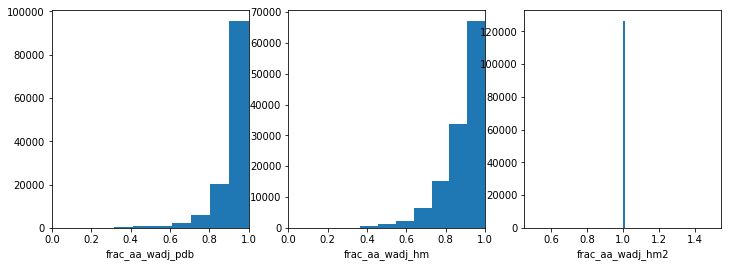

In [35]:
fg, axs = plt.subplots(1, 3, figsize=(12, 4))

plt.sca(axs[0])
_ = plt.hist(homology_models_dataset["frac_aa_wadj_pdb"])
plt.xlim(0, 1)
plt.xlabel("frac_aa_wadj_pdb")

plt.sca(axs[1])
_ = plt.hist(homology_models_dataset["frac_aa_wadj_hm"])
plt.xlim(0, 1)
plt.xlabel("frac_aa_wadj_hm")

plt.sca(axs[2])
_ = plt.hist(homology_models_dataset["frac_aa_wadj_hm2"], bins=100)
# plt.xlim(0, 1.1)
plt.xlabel("frac_aa_wadj_hm2")

### Adjacency matrix limits

In [36]:
def validate_adjacency_df(df, adj_column_1, adj_column_2):
    assert (df[adj_column_1].apply(min) >= 0).all()
    assert (df[adj_column_2].apply(min) >= 0).all()
    
    assert (
        df[adj_column_1].apply(max) <
        df['sequence'].str.len()
    ).all()

    assert (
        df[adj_column_2].apply(max) <
        df['sequence'].str.len()
    ).all()

    assert (
        (df[adj_column_1].apply(lambda l: len(set(l))) /
         df['sequence'].str.len()) > 0.5
    ).all()

    assert (
        (df[adj_column_2].apply(lambda l: len(set(l))) /
         df['sequence'].str.len()) > 0.5
    ).all()
    
    
# validate_adjacency_df(homology_models_dataset, "adjacency_idx_1_from_pdb", "adjacency_idx_2_from_pdb")
# validate_adjacency_df(homology_models_dataset, "adjacency_idx_1_from_hm", "adjacency_idx_2_from_hm")b

### `homology_models_dataset`

In [44]:
homology_models_dataset_final = (
    homology_models_dataset[
        (homology_models_dataset['frac_aa_wadj_pdb'] > 0.6) &
        (homology_models_dataset['frac_aa_wadj_hm'] > 0.6)
    ]
).copy()

Text(0.5, 0, 'frac_aa_wadj_hm2')

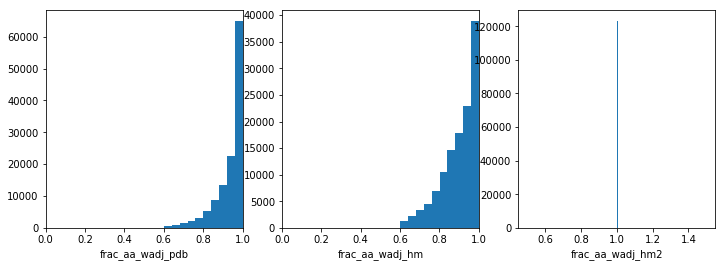

In [45]:
fg, axs = plt.subplots(1, 3, figsize=(12, 4))

plt.sca(axs[0])
_ = plt.hist(homology_models_dataset_final["frac_aa_wadj_pdb"])
plt.xlim(0, 1)
plt.xlabel("frac_aa_wadj_pdb")

plt.sca(axs[1])
_ = plt.hist(homology_models_dataset_final["frac_aa_wadj_hm"])
plt.xlim(0, 1)
plt.xlabel("frac_aa_wadj_hm")

plt.sca(axs[2])
_ = plt.hist(homology_models_dataset_final["frac_aa_wadj_hm2"], bins=100)
# plt.xlim(0, 1.1)
plt.xlabel("frac_aa_wadj_hm2")

## Run network

In [46]:
%run trained_networks.ipynb

### Predictions using PDB adjacencies

In [ ]:
input_df = homology_models_dataset_final.copy()

input_df['adjacency_idx_1'] = input_df[f'adjacency_idx_1_from_pdb']
input_df['adjacency_idx_2'] = input_df[f'adjacency_idx_2_from_pdb']

for network_name in reversed(NETWORK_NAME.split(',')):
    predict_with_network = predict_with_dcn_old if 'dcn_old' in network_name else predict_with_dcn
    homology_models_dataset_final[f'{network_name}_pdb'] = (
        predict_with_network(
            input_df.copy(),
            network_state=TRAINED_NETWORKS[network_name]['network_state'],
            network_info=TRAINED_NETWORKS[network_name]['network_info'],
        )
    )

Network name: 'DCN_9c5a963'
Final output_channels: 256


### Predictions using HM adjacencies (incorrect)

In [ ]:
input_df = homology_models_dataset_final.copy()

input_df['adjacency_idx_1'] = input_df[f'adjacency_idx_1_from_hm']
input_df['adjacency_idx_2'] = input_df[f'adjacency_idx_2_from_hm']

for network_name in NETWORK_NAME.split(','):
    predict_with_network = predict_with_dcn_old if 'dcn_old' in network_name else predict_with_dcn
    homology_models_dataset_final[f'{network_name}_hm'] = (
        predict_with_network(
            input_df.copy(),
            network_state=TRAINED_NETWORKS[network_name]['network_state'],
            network_info=TRAINED_NETWORKS[network_name]['network_info'],
        )
    )

### Predictions using HM adjacencies (correct)

In [ ]:
input_df = homology_models_dataset_final.copy()

input_df['adjacency_idx_1'] = input_df[f'hm_residue_idx_1']
input_df['adjacency_idx_2'] = input_df[f'hm_residue_idx_2']

for network_name in NETWORK_NAME.split(','):
    predict_with_network = predict_with_dcn_old if 'dcn_old' in network_name else predict_with_dcn
    homology_models_dataset_final[f'{network_name}_hm2'] = (
        predict_with_network(
            input_df.copy(),
            network_state=TRAINED_NETWORKS[network_name]['network_state'],
            network_info=TRAINED_NETWORKS[network_name]['network_info'],
        )
    )

In [ ]:
homology_models_dataset.columns

In [ ]:
table = pa.Table.from_pandas(homology_models_dataset)
pq.write_table(table, NOTEBOOK_PATH.joinpath("homology_models_dataset_cache.parquet"), version='2.0')

In [ ]:
raise Exception

# Analysis

In [ ]:
def plot(df, columns):
    
    mat = np.zeros((len(columns), len(columns)), float)
    for i, c1 in enumerate(columns):
        for j, c2 in enumerate(columns):
            x = df[c1] if 'dope' not in c1 else -df[c1]
            y = df[c2] if 'dope' not in c2 else -df[c2]
            mat[i, j] = stats.spearmanr(x, y)[0]

    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(mat)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(columns)))
    ax.set_yticks(np.arange(len(columns)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(columns)
    ax.set_yticklabels(columns)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(columns)):
        for j in range(len(columns)):
            text = ax.text(j, i, f"{mat[i, j]:.2f}", ha="center", va="center", color="w")

    ax.set_title("Harvest of local farmers (in tons/year)")
    fig.tight_layout()
    plt.show()

In [ ]:
columns = [
    'rosetta_score',
    'dope_score', 'dope_score_norm', 'ga341_score',
    
    "identity_calc",
    # "coverage_calc", 

    "score",  # "probability", "evalue",
    "identity", "similarity", "sum_probs",
    
    # "query_match_length",
    "template_match_length",
] + [
    f"{network_name}{suffix}"
    for network_name in NETWORK_NAME.split(',')
    for suffix in [
        "_pdb",
        "_hm",
        "_hm2",
    ]
]


plot(homology_models_dataset, columns)

In [ ]:
target_columns = ['rosetta_score', 'dope_score', 'dope_score_norm', 'ga341_score']

feature_columns = [
#     "coverage", 
    "identity_calc",
    "score",  # "probability", "evalue",
    "identity", "similarity", "sum_probs",
    
#     "query_match_length", 
    "template_match_length",
] + [
    f"{network_name}{suffix}"
    for network_name in NETWORK_NAME.split(',')
    for suffix in [
        "_pdb",
        "_hm",
        "_hm2",
    ]
]

correlations = {y_col: {x_col: [] for x_col in feature_columns} for y_col in target_columns}

df = homology_models_dataset.dropna(subset=target_columns + feature_columns)

for query_id, group in df.groupby('query_id'):
    assert (group['sequence'].str.replace('-', '') == group['sequence'].iloc[0].replace('-', '')).all()
    assert (group['query_match_length'] == group['query_match_length'].iloc[0]).all()
    
    if len(group) < 3:
        print("skipping")
        continue
    
    df = group.copy()
    for y_col in target_columns:
#         df = df.dropna(subset=[y_col])
        if len(df) < 3 or len(set(df[y_col])) == 1:
            print(f"skipping a {y_col}")
            continue
        for x_col in feature_columns:
#             df = group.dropna(subset=[x_col])
            if len(df) < 3 or len(set(df[x_col])) == 1:
                print(f"skipping b {x_col}")
                continue
            corr, pvalue = stats.spearmanr(df[x_col], df[y_col])
            correlations[y_col][x_col].append(corr)

In [ ]:
for k in target_columns:
    print(k)
    corr = [np.array(correlations[k][f]) for f in correlations[target_columns[0]]]
    if k not in ['ga341_score']:
        corr = [-c for c in corr]
    _ = plt.boxplot(corr)
    plt.hlines(0, 0.5, 9.6)
    plt.show()

In [ ]:
correlations['rosetta_score']

In [ ]:
_ = plt.boxplot([correlations['rosetta_score'][f] for f in correlations['rosetta_score']])

# Predictions

## Make plot

In [ ]:
cmap = plt.cm.get_cmap('Set1', 10)

In [ ]:
target = 'dope_score'

features = (
    [
        "identity_calc",
        
        "identity", "similarity",
        
        "score",  # "probability", "evalue",
        "sum_probs",
        
        "template_match_length",
    ]
    + [
        f"{network_name}{suffix}"
        for network_name in NETWORK_NAME.split(',')
        for suffix in [
#             "_pdb",
#             "_hm",
            "_hm2"
        ]
    ]
)

DATA = {}
for target in ['dope_score', 'dope_score_norm', 'ga341_score', 'rosetta_score']:
    data = []
    for feature in features:
        df = homology_models_dataset[[feature, target]].dropna()
        corr = stats.spearmanr(df[feature], df[target])
        data.append((feature, corr.correlation, corr.pvalue))
    DATA[target] = pd.DataFrame(data, columns=['feature', 'correlation', 'pvalue'])

In [ ]:
for target, df in DATA.items():
    x = np.arange(len(df))
    c = [
        cmap(2)
        if f.rpartition('_')[0] in NETWORK_NAME.split(',')
        else cmap(1)
        for f in df['feature']
    ]
    corr = df['correlation']
    if target not in ['ga341_score']:
        corr = -corr
    plt.bar(x, corr, color=c)
    plt.xticks(x, df['feature'], rotation=45)
    plt.ylim(-0.1, 1)
    plt.ylabel("Correlation")
    plt.title(f"{target}")
    plt.show()

In [ ]:
homology_models_dataset['rosetta_score'].hist(range=(-1000, 1000))

In [ ]:
def plot(col1, col2):
    df = homology_models_dataset[[col1, col2]].dropna()
    if len(df) != len(homology_models_dataset):
        print(f"Removed {len(homology_models_dataset) - len(df)} columns with nulls!")
    x = df[col1]
    y = df[col2]
    corr = stats.spearmanr(x, y)
    plt.plot(x, y, 'rx')
    plt.title(f"{corr.correlation:.3f} ({corr.pvalue:.3f})")
    plt.xlabel(col1)
    plt.ylabel(col2)

In [ ]:
plot('rosetta_score', 'dcn_old_0_pdb')

In [ ]:
plot('dope_score_norm', 'network_pred_pdb')

In [ ]:
plot('ga341_score', 'network_pred_pdb')